# Artigo 1 - CIÊNCIA DE DADOS E APRENDIZADO DE MÁQUINA PARA PREDIÇÃO EM SÉRIES TEMPORAIS FINANCEIRAS

# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('Inteligencia_Artificial/Trabalho de Conclusão de Curso/Base de Dados/BPAC_30m_2021.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume,Volume MA
0,2020-11-25T10:00:00-03:00,19.8550,19.9975,19.8000,19.8350,1427600,616260
1,2020-11-25T10:30:00-03:00,19.8400,19.9375,19.8125,19.8450,430000,608480
2,2020-11-25T11:00:00-03:00,19.8300,19.9275,19.8225,19.9075,130000,578580
3,2020-11-25T11:30:00-03:00,19.9150,19.9550,19.7375,19.8325,830800,588820
4,2020-11-25T12:00:00-03:00,19.8325,19.9475,19.7775,19.8425,420800,572060


In [2]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [3]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [4]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

#Coluna binária
data['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(data)

,price,return,direction
0,19.8350,NaN,0
1,19.8450,0.000504,1
2,19.9075,0.003144,1
3,19.8325,-0.003775,0
4,19.8425,0.000504,1
...,...,...,...
5647,22.6600,0.033658,1
5648,22.8300,0.007474,1
5649,23.0200,0.008288,1
5650,23.1100,0.003902,1


In [5]:
#Para a previsão do mercado de ações, é crucial encontrar dependências de tempo bem definidas
lags = 4

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     data[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
data.dropna(inplace=True)

In [6]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4
5,19.7600,-0.004166,0,0.000504,-0.003775,0.003144,0.000504
6,19.7875,0.001391,1,-0.004166,0.000504,-0.003775,0.003144
7,19.8525,0.003280,1,0.001391,-0.004166,0.000504,-0.003775
8,19.8875,0.001761,1,0.003280,0.001391,-0.004166,0.000504
9,19.9850,0.004891,1,0.001761,0.003280,0.001391,-0.004166
...,...,...,...,...,...,...,...
5647,22.6600,0.033658,1,-0.002279,-0.000910,0.003646,0.005954
5648,22.8300,0.007474,1,0.033658,-0.002279,-0.000910,0.003646
5649,23.0200,0.008288,1,0.007474,0.033658,-0.002279,-0.000910
5650,23.1100,0.003902,1,0.008288,0.007474,0.033658,-0.002279


In [7]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense
#-----------------------------------------------------------
# Importa a LSTM
#-----------------------------------------------------------
from tensorflow.keras.layers import LSTM
#-----------------------------------------------------------
# Importa Layer weight regularizers
# https://keras.io/api/layers/regularizers/
#-----------------------------------------------------------
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam, RMSprop, Adamax

#optimizer = Adam(learning_rate=0.0001)

# https://keras.io/api/optimizers/adamax/
optimizer = Adamax(learning_rate=0.001)

In [8]:
## Definir o que é isso e para que server?
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [9]:
set_seeds()

#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
# Se cada amostra de entrada tiver 4 passos de tempo, onde cada passo de tempo 
# consiste em 1 valor de recurso, então a forma de entrada seria (4, 1).
# https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers
# input_shape = Deve ser 3 dimensôes, batch_size, timestep, the number of units in one input sequence
#-----------------------------------------------------------

model.add(LSTM(20, input_shape=(1,lags),return_sequences=True))
model.add(LSTM(16,kernel_regularizer=regularizers.L1(0.02),return_sequences=True))
model.add(LSTM(8,kernel_regularizer=regularizers.L1(0.02),return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
# https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function
# https://keras.io/api/losses/
model.compile(optimizer=optimizer,
 loss='binary_crossentropy',
metrics=['accuracy'])
# https://keras.io/api/metrics/
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 20)             2000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2368      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 8)              800       
_________________________________________________________________
dense (Dense)                (None, 1, 1)              9         
Total params: 5,177
Trainable params: 5,177
Non-trainable params: 0
_________________________________________________________________


In [10]:
#-----------------------------------------------------------
# Define a data limite entre os dados de treinamento e teste.
#-----------------------------------------------------------
cutoff = 2740

"""                      TREINAMENTO                      """
#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento.
#-----------------------------------------------------------
training_data = data[data.index < cutoff].copy()
#print(len(training_data[cols]))


"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de treinamentos e coloca na variavel X_train
#-----------------------------------------------------------
X_train = training_data[cols].values

#-----------------------------------------------------------
# Redefine os dados de treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_train = X_train.reshape(len(X_train),1,lags)
#print(X_train.shape)


"""-------------------Dados de Saida----------------------"""

#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de treinamento e coloca na variavel Y_train
#-----------------------------------------------------------
Y_train = training_data['direction'].values


#-----------------------------------------------------------
# Redefine os dados de direção treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_train = Y_train.reshape(len(Y_train),1,1)




"""                           TESTE                     """
#-----------------------------------------------------------
# Define os conjuntos de dados de teste.
#-----------------------------------------------------------
test_data = data[data.index >= cutoff].copy()


"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de teste e coloca na variavel X_test
#-----------------------------------------------------------
X_test = test_data[cols].values

#-----------------------------------------------------------
# Redefine os dados de 'Lag' teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_test = X_test.reshape(len(X_test),1,lags)


#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de teste e coloca na variavel Y_teste
#-----------------------------------------------------------
Y_teste = test_data['direction'].values


#-----------------------------------------------------------
# Redefine os dados de direção teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_teste = Y_teste.reshape(len(Y_teste),1,1)




In [11]:
# training_data_[cols]
# training_data[cols]

In [12]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
# model.fit(training_data[cols], # Lags
#    training_data['direction'], # 0 e 1
#    epochs=250, verbose=False, batch_size=100,
#    validation_split=0.5, shuffle=False)

model.fit(X_train, # Lags
    Y_train, # 0 e 1
    epochs=50, verbose=False,
    validation_split=0.2, shuffle=False)

CPU times: user 32.8 s, sys: 2.07 s, total: 34.8 s
Wall time: 24.5 s


In [13]:
res = pd.DataFrame(model.history.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,4.711611,0.496344,3.667879,0.500914
1,2.872568,0.488574,2.140846,0.499086
2,1.630331,0.503199,1.184868,0.499086
3,0.935706,0.503199,0.775747,0.499086
4,0.726509,0.503199,0.699174,0.499086


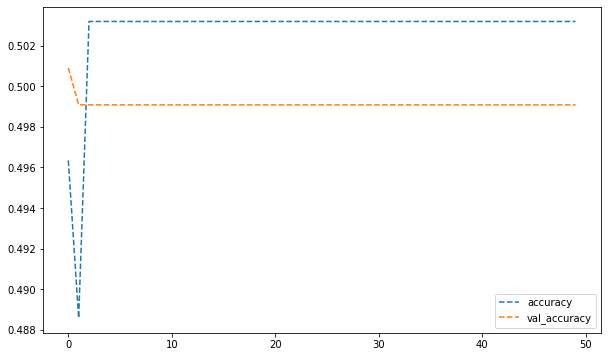

In [14]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [15]:
model.evaluate(X_train, training_data['direction'])

86/86 [==============================] - 1s 2ms/step - loss: 0.6977 - accuracy: 0.5024


[0.6976985335350037, 0.5023766160011292]

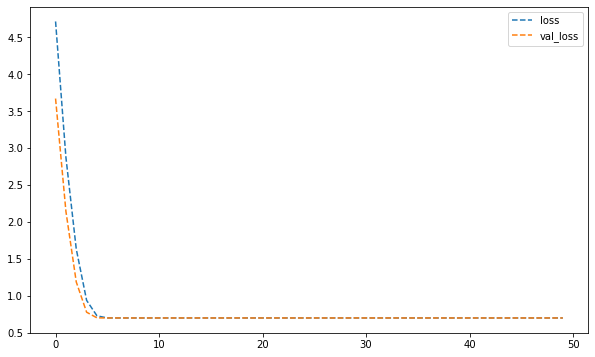

In [16]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');